# **Import the dataset**

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import elu
from keras import backend as K
import pandas as pd
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [6]:
dataset = pd.read_csv('../../dataset/blood_dataset.csv').iloc[:, 2:]
data1, data2 =  train_test_split(dataset, test_size=0.4, random_state=42)
train1, test1  = train_test_split(data1, test_size=0.2, random_state=46)
train2, test2  = train_test_split(data2, test_size=0.2, random_state=32)

In [7]:
train1_X = train1.iloc[:,:-1]
train1_y = train1.iloc[:,-1]
test1_X = test1.iloc[:,:-1]
test1_y = test1.iloc[:,-1]

In [8]:
train1_X.head()

,A1BG..1.,A1CF..29974.,A2M..2.,A2ML1..144568.,A3GALT2..127550.,A4GALT..53947.,A4GNT..51146.,AAAS..8086.,AACS..65985.,AADAC..13.,...,ZWILCH..55055.,ZWINT..11130.,ZXDA..7789.,ZXDB..158586.,ZXDC..79364.,ZYG11A..440590.,ZYG11B..79699.,ZYX..7791.,ZZEF1..23140.,ZZZ3..26009.
650,0.147080,0.445694,0.017483,0.007169,0.045457,0.014632,0.067986,0.403468,0.035305,0.042075,...,0.123353,0.942294,0.054111,0.003993,0.023763,0.006771,0.074534,0.030963,0.040735,0.273131
819,0.041403,0.044806,0.015059,0.017849,0.014064,0.072826,0.114187,0.050226,0.030321,0.013896,...,0.833055,0.716253,0.012140,0.015239,0.019902,0.045649,0.077900,0.049628,0.058832,0.250032
704,0.010526,0.014056,0.043156,0.031235,0.018561,0.056506,0.022698,0.173124,0.020605,0.015097,...,0.010972,0.787811,0.073192,0.029455,0.077723,0.019042,0.092804,0.050415,0.481685,0.427200
898,0.021123,0.058064,0.021918,0.014077,0.175457,0.020636,0.015101,0.076689,0.224626,0.043011,...,0.657375,0.309251,0.018342,0.016745,0.041365,0.013402,0.059737,0.085355,0.077031,0.298912
389,0.037622,0.035071,0.052090,0.060095,0.084555,0.038729,0.086327,0.719724,0.044339,0.039472,...,0.153459,0.165303,0.011806,0.087887,0.019427,0.031437,0.047821,0.103173,0.265542,0.112986


# **Ensemble model of NN**

The idea is to fit $k + 1$ NNs models:

1. the first one will be the one trained on all lung obs and an equal number of non-lung obs randomly selected
2. ...
3. ...

And so forth up top the $k$-th model. 
We then define the prediction in voting fashion, possibly with a weight (i.e. a vote for lung could count more than a vote for non-lung).

As loss function we use the Focal Loss. Here’s the main idea: in our dataset, we will naturally have some training examples that are easier to classify than others (non-lung). During training, these examples will be classified with 99% accuracy, while other more challenging ones may still exhibit poor performance. The problem is that those easily classified training examples are still contributing to the loss. Why are we still giving them equal weight when there are other more challenging data points that if correctly classified can contribute much more to our overall accuracy?

$$FL(p_t) = \alpha \cdot (1-p_t)^\gamma \cdot \log{p_t}$$

Focal loss down-weights the well-classified examples. This has the net effect of putting more training emphasis on that data that is hard to classify! In a practical setting where we have a data imbalance, our majority class will quickly become well-classified since we have much more data for it. Thus, in order to insure that we also achieve high accuracy on our minority class, we can use the focal loss to give those minority class examples more relative weight during training. 

In [9]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as y_pred
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

**$k$ undersampling NNs models**

In [10]:
models = []

metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]

for i in range(20):
    # create random undersampling of majority class
    rus = RandomUnderSampler(random_state=i)
    X_res, y_res = rus.fit_resample(train1_X, train1_y)


    model_i = keras.Sequential(
    [
        keras.layers.Dense(400, activation="relu", input_shape=(17393,)),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
    )


    model_i.compile(
        optimizer='adam', loss="binary_crossentropy", metrics=metrics
        )

    model_i.fit(X_res, y_res, batch_size=len(X_res), epochs=40, verbose=0)

    models.append(model_i)
        

2021-12-10 12:52:44.643119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:52:48.166043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:52:50.599011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:52:53.111962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:52:55.618458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:52:57.976025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:53:00.426096: I tensorflow/core/grappler/optimizers/cust

**Confusion matrix on test**

In [11]:
sum_pred = 0
for i in range(len(models)):
    sum_pred += models[i].predict(test1_X)

ensemble_prediction = (sum_pred/len(models)) > 0.5
conf_matr = confusion_matrix(test1_y, ensemble_prediction)
conf_matr

2021-12-10 12:54:50.877338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:54:51.034870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:54:51.139378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:54:51.233279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:54:51.321159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:54:51.406592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-10 12:54:51.495323: I tensorflow/core/grappler/optimizers/cust

array([[109,   1],
       [  0,  13]])

In [12]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

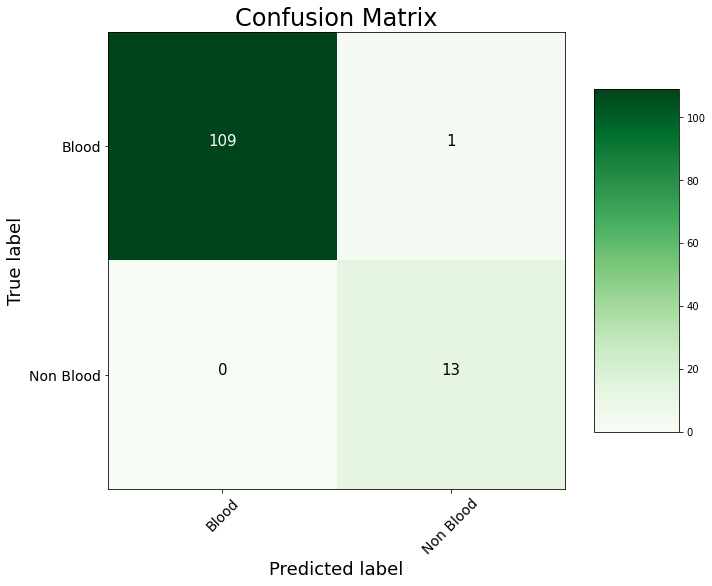

In [16]:
plot_confusion_matrix(conf_matr, classes = ["Blood", "Non Blood"],
                        title = 'Confusion Matrix')